## CS5304 - Machine Learning - Assignment 1


### Weisi Zhang - wz337    Collaborator: Dexing Xu - dx47 

### Deadline: February 5, 2018; Points: 15 

For this assignment, you will be required to classify documents from the RCV1
dataset, which is an archive of over 800k manually categorized newswire stories
made available by Reuters, Ltd. for research purposes [1]. The first 23,149
samples will be used for training, 10k are randomly chosen from the remaining
for validation, and 50k will be randomly chosen for testing. The ids used for
validation are provided in validation.txt and the ids for testing are hidden.
Use scikit-learn [2] to load the data. <br>
[1]: http://www.jmlr.org/papers/volume5/lewis04a/lewis04a.pdf <Br>
[2]: http://scikit-learn.org/stable/datasets/rcv1.html <Br>

# 1. k-Nearest-Neighbors and Naive Bayes

## 1a. (3 Points) Classification with kNN. 
Use the KNeighborsClassifier from scikit- learn to classify documents in the validation set. Only consider the labels from labels.txt. Find a good value for K by exploring a few options. Wrap your classifier in a Python class called CS5304KNNClassifier and it should have a train and predict method. We will be calling these methods during grading. You'll also need to submit a file called ks.txt that includes the value for K you've chosen for each label. For this exercise, only use the first 1000 training examples.

In [3]:
import argparse

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_rcv1

In [4]:
def load_labels(path_to_labels):
    labels = pd.read_csv(path_to_labels, header=None, 
                         names = ["label"], dtype=np.int32)
    return labels['label'].tolist()

In [5]:
def load_training_data():
    data = fetch_rcv1(subset='train')
    return data.data, data.target.toarray(), data.sample_id

In [6]:
def load_validation_data(path_to_ids):
    data = fetch_rcv1(subset='test')
    ids = pd.read_csv(path_to_ids, names=['id'], dtype=np.int32)
    mask = np.isin(data.sample_id, ids['id'])
    validation_data = data.data[mask]
    validation_target = data.target[mask].toarray()
    validation_ids = data.sample_id[mask]
    return validation_data, validation_target, validation_ids

In [54]:
class CS5304BaseClassifier(object):
    def __init__(self):
        pass

    def train(self, x, y):
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError

In [52]:
from sklearn.neighbors import KNeighborsClassifier
class CS5304KNNClassifier:
    
    def __init__(self, n_neighbors=3):
        super(CS5304KNNClassifier, self).__init__()
        self.n_neighbors = n_neighbors
    
    def train(self, X_train, y_train):
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors)
        self.model.fit(X_train, y_train) 
        
    def predict(self, X_test):
        if self.model:
            return self.model.predict(X_test)
        else:
            raise "No model has been trained yet"
    
    def get_score(self, X_test, y_test):
        if self.model:
            return self.model.score(X_test, y_test)
        else:
            raise "No model has been trained yet"

In [9]:
train_data, train_target, train_ids = load_training_data()
eval_data, eval_target, eval_ids = load_validation_data('validation.txt')
X, y = train_data[:1000, :], train_target[:1000, :]

## Choose K

In order to choose an ideal k for each label, we run a 5-fold cross validation on training data for each label. For each label, we tried different odd number k, ranging from 1 to 41. For each k value, we got 5 accuracy score for each fold and took an average. Then, we compared the average accuracy score for each k, picked the one with highest accuracy, and stored it for each k.

In [165]:
#cross validation (5-fold) on training set to choose k
def choose_k(X, y, label):
    k_and_accuracy = dict()
    for k in range(1, 41, 2):
        my_knn = CS5304KNNClassifier(k)
        avg = 0.0
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            my_knn.train(X_train, y_train) 
            output = my_knn.predict(X_test)
            check_output(output, y_test)
            avg += my_knn.get_score(X_test, y_test)
        k_and_accuracy[k] = avg / kf.get_n_splits()
        #print ("The average accuracy for k =", k, "is", avg / kf.get_n_splits())
    max_accuracy = max(k_and_accuracy.values())
    optimal_k = [k for k, v in k_and_accuracy.items() if v == max_accuracy][0]
    print ("Optimal k for label", label, "is ", 
           optimal_k, " and accuracy is", max_accuracy)
    return label, optimal_k

#check output dimension
def check_output(output, y):
    assert type(output) == np.ndarray
    assert output.ndim == 1
    assert output.shape[0] == y.shape[0]

Below shows the optimal k for each label and its corresponding accuracy score from cross validation.

In [166]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)

#getting k for each binary classifer and store them in a dictionary
k_for_labels = dict()
for label in load_labels('labels.txt'):
    k, v = choose_k(X, y[:, label], label)
    k_for_labels[k] = v
    
k_for_labels

Optimal k for label 4 is  27  and accuracy is 0.9400000000000001
Optimal k for label 5 is  35  and accuracy is 0.952
Optimal k for label 7 is  27  and accuracy is 0.942
Optimal k for label 33 is  3  and accuracy is 0.859
Optimal k for label 59 is  7  and accuracy is 0.9019999999999999
Optimal k for label 70 is  5  and accuracy is 0.891
Optimal k for label 83 is  7  and accuracy is 0.959
Optimal k for label 95 is  17  and accuracy is 0.9550000000000001
Optimal k for label 98 is  3  and accuracy is 0.96
Optimal k for label 102 is  39  and accuracy is 0.923


{4: 27, 5: 35, 7: 27, 33: 3, 59: 7, 70: 5, 83: 7, 95: 17, 98: 3, 102: 39}

Then, we run KNN with the validation set with the k we picked above. Below shows the accuracy score for the validation set with label and k indicated on KNN model.

In [172]:
#running models on validation set
print ("Validation Result for KNN")
for label, k in k_for_labels.items():
    my_knn_for_testing = CS5304KNNClassifier(k)
    my_knn_for_testing.train(X, y[:, label])
    output = my_knn_for_testing.predict(eval_data)
    check_output(output, eval_target[:, label] )
    print ("For label", label, "and k = ", k, 
           "accuracy: ", 
           my_knn_for_testing.get_score(eval_data, eval_target[:, label]))

Validation Result for KNN
For label 4 and k =  27 accuracy:  0.9221
For label 5 and k =  35 accuracy:  0.9518
For label 7 and k =  27 accuracy:  0.909
For label 33 and k =  3 accuracy:  0.8101
For label 59 and k =  7 accuracy:  0.8907
For label 70 and k =  5 accuracy:  0.9
For label 83 and k =  7 accuracy:  0.9533
For label 95 and k =  17 accuracy:  0.9649
For label 98 and k =  3 accuracy:  0.9537
For label 102 and k =  39 accuracy:  0.9126


In [449]:
#running models on validation set
print ("Validation Result for KNN")
my_knn_for_testing = CS5304KNNClassifier(29)
my_knn_for_testing.train(X, y[:, 33])
output = my_knn_for_testing.predict(eval_data)
check_output(output, eval_target[:, 33] )
print ("For label", label, "and k = ", k, "accuracy: ", 
       my_knn_for_testing.get_score(eval_data, eval_target[:, 33]))

Validation Result for KNN
For label 102 and k =  39 accuracy:  0.8451


## 1b. (3 Points) Classification with NB. 
Use the BernoulliNB from scikit-learn
to classify documents in the validation set. Only consider the labels from
labels.txt. Wrap your classifier in a Python class called CS5304NBClassifier
and it should have a train and predict method. Use all the training examples.

In [55]:
from sklearn.naive_bayes import BernoulliNB

class CS5304NBClassifier(CS5304BaseClassifier):
    
    def __init__(self):
        super(CS5304NBClassifier, self).__init__()
    
    def train(self, X_train, y_train):
        self.model = BernoulliNB().fit(X_train, y_train)
    
    def predict(self, X_test):
        if self.model:
            return self.model.predict(X_test)
        else: 
            raise "No model has been trained yet"   
    
    def get_score(self, X_test, y_test):
        if self.model:
            return self.model.score(X_test, y_test)
        else:
            raise "No model has been trained yet"
        

Below shows the accuracy score for the validation set with label and k indicated on Bernoulli_NB Classifier.

In [173]:
print ("Validation result for Bernoulli_NB Classifier")
for label in load_labels('labels.txt'):
    nb_classifier = CS5304NBClassifier()
    nb_classifier.train(train_data, train_target[:, label])
    validation_score = nb_classifier.get_score(eval_data, eval_target[:, label])
    print ("For label", label,
           ", the accuracy on validation set is: ", validation_score)
    

Validation result for Bernoulli_NB Classifier
For label 4 , the accuracy on validation set is:  0.8109
For label 5 , the accuracy on validation set is:  0.8824
For label 7 , the accuracy on validation set is:  0.9212
For label 33 , the accuracy on validation set is:  0.7931
For label 59 , the accuracy on validation set is:  0.9115
For label 70 , the accuracy on validation set is:  0.8991
For label 83 , the accuracy on validation set is:  0.9033
For label 95 , the accuracy on validation set is:  0.9634
For label 98 , the accuracy on validation set is:  0.9735
For label 102 , the accuracy on validation set is:  0.9018


## 1c. (1 Points)  Data Analysis. 
Which label is the most difficult to classify? Why do you think this is the case?

## Answer

From both of the validation results above (KNN and Bernoulli_NB), we can see that despite of different classification method, the class with label 33 has the lowest accuracy (0.8101 for KNN and 0.7931 for Bernoulli_NB), thereby the most difficult one to classify.

By examing the prior distribution on both the training (first 1,000 and total of 23,149) and the validation set, we can see that label 33 takes up about 50% of the total numbers while all the other labels are not. We suspect this is the reason that it is the most difficult to classify.

Since there are a lot of data points with label 33, we expect the variance within the class to be high. We can also confirm that by looking at the best k chosen by cross validation, even though there are many true labels of 33, the best k (k = 3) is surprisingly small. This is probably resulted from the variance within class is high. Thus, a higher value of K would lead to worse performance for label 33.

As for Naive Bayes Classifier, it employs a very simple linear hypothesis function and it also assumes the feature to be independent. Therefore, NB suffers from high bias, as it could not sufficiently represent many complex situations (data is very spread out in our case). The simplicity of the model leads to the low performance on this particular label. 

In [441]:
#check prior distribution for each classifier in the training set 
# (first 1000 samples from training_data)
print ("Prior distribution for each classifier in the first 1,000 training samples")
for label in load_labels('labels.txt'):
    print (label, ": ", np.sum(train_target[:1000, label])/train_target[:1000, label].shape[0])

Prior distribution for each classifier in the first 1,000 training samples
4 :  0.2
5 :  0.146
7 :  0.058
33 :  0.536
59 :  0.151
70 :  0.276
83 :  0.064
95 :  0.072
98 :  0.084
102 :  0.239


In [442]:
#check prior distribution for training set (all samples from training_data)
print ("Prior distribution for each classifier in all training samples")
for label in load_labels('labels.txt'):
    print (label, ": ", np.sum(train_target[:, label])/train_target[:,label].shape[0])

Prior distribution for each classifier in all training samples
4 :  0.18052615663743574
5 :  0.1022074387662534
7 :  0.08337293187610696
33 :  0.46593805347963196
59 :  0.14899131711953
70 :  0.3010929197805521
83 :  0.07114778176163117
95 :  0.06894466283640761
98 :  0.10976716056849108
102 :  0.254093049375783


In [443]:
#check prior distribution for validation set (all samples from validation set)
print ("Prior distribution for each classifier for all samples")
for label in load_labels('labels.txt'):
    print (label, ": ", np.sum(eval_target[:, label])/eval_target[:,label].shape[0])

Prior distribution for each classifier for all samples
4 :  0.1947
5 :  0.107
7 :  0.0922
33 :  0.4804
59 :  0.1421
70 :  0.2935
83 :  0.0703
95 :  0.0677
98 :  0.1059
102 :  0.2578


# 2. k-Means

## 2a. (6 Points) Classification with k-Means. 
Use the KMeans from scikit-learn to classify documents in the validation set. Only consider the first 10 labels. Wrap
this kMeans classifier in CS5304KMeansClassifier with a train and predict method, which will be called during grading. Use all the training examples. <br>
Hint: Find the centroids for the training data. Pass these to scikit-learn's KMeans as the value for init.

In [ ]:
from sklearn.cluster import KMeans
import scipy
class CS5304KMeansClassifier():
    
    def __init__(self, n_clusters = 2):
        self.n_clusters = n_clusters
    
    def train(self, X, y):
        init_centroids = self.get_init_centroid(X,y)
        self.model = KMeans(n_clusters=self.n_clusters, 
                            init=init_centroids, n_init=1).fit(X)
    
    def predict(self, X):
        if self.model: 
            return self.model.predict(X)
        else:
            raise "No model has been trained yet"
    
    def get_init_centroid(self, X, y):
        true_set = [i for i, j in enumerate(y) if j == 1]
        false_set = [i for i, j in enumerate(y) if j == 0]
        true_cluster = X[true_set]
        false_cluster = X[false_set]
        true_centroid = X[true_set].mean(axis = 0)
        false_centroid = X[false_set].mean(axis = 0)
        return np.concatenate((false_centroid, true_centroid), axis = 0)
    
    def get_score(self, X, y):
        if self.model:
            n_samples = X.shape[0]
            y_hat = np.array(self.model.predict(X)).flatten()
            y_true_label = np.array(y).flatten()
            count = len([i for i in range(n_samples) 
                         if y_hat[i] == y_true_label[i]])
            return count / float(n_samples)
        else:
            raise "No model has been trained yet"
    
    def get_final_centroid(self):
        return self.model.cluster_centers_
    

In [ ]:
for label in load_labels('labels.txt'):
    kmeans_classifier = CS5304KMeansClassifier()
    kmeans_classifier.train(train_data, train_target[:, label])
    print ("For label", label, ", the accuracy score is:", 
           kmeans_classifier.get_score(eval_data, eval_target[:, label]))

## 2b. (1 Point) Visualizing Clusters. 
Visualize the predictions from KMeans for label 33 with a 2-dimensional plot. You'll need to choose a dimensionality
reduction technique (such as TruncatedSVD). For plotting, use matplotlib.

In [11]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [12]:
kmeans_classifier = CS5304KMeansClassifier()
kmeans_classifier.train(train_data, train_target[:, 33])
kmeans_classifier.get_score(eval_data, eval_target[:, 33])

0.6193

In [13]:
predicted_33 = kmeans_classifier.predict(eval_data)

In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix

svd = TruncatedSVD(n_components=2, random_state=42)
eval_data_truncated = svd.fit_transform(eval_data)

In [35]:
def get_color(y):
    color = []
    for label in y:
        if label == 1:
            color.append('c')
        else:
            color.append('y')
    return color

In [36]:
def draw_plot(X, y):
    color_array = get_color(y)
    plt.scatter(X[:,0], X[:,1],color=color_array, s=5)


Below is the 2-dimensional plot to visualize predictions from KMeans for label 33. 

Text(0.5,1,'kMeans (n_clusters = 2, initial centroids given)')

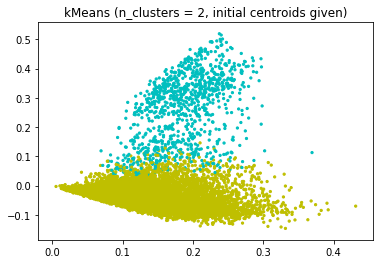

In [37]:
draw_plot(eval_data_truncated, predicted_33)
plt.title("kMeans (n_clusters = 2, initial centroids given)")

Below is the 2-dimensional plot to visualize distribution for label 33 in the evaluation dataset.

Text(0.5,1,'Prior Distribution for label 33')

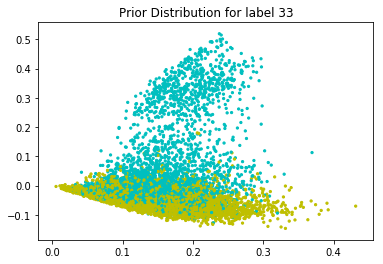

In [38]:
draw_plot(eval_data_truncated, eval_target[:, 33])
plt.title("Prior Distribution for label 33")

## 2c. (1 Point) Data Analysis.
Train a new KMeans model for label 33. This time, initialize the centroids randomly (if you use the scikit-learn method fit, then don't provide a value for y). Visualize the clusters using the same dimensions as from 2b. Do the clusters look similar as when you provided the labels? What do the clusters look like if you use 3 or 4 clusters instead of 2? Explain why.

## Answer

Comparing the clusters using the same dimensions as from 2b, we can see that the two clusters looks very similar and almost identical (the points are cluttering with each other so it is hard to tell, but it should be the same). 

This make senses. If we refer back to the prior distribution we get from 1c, we can see that almost half of the data points (4804) in the evaluation set is labeled 33. So even if we don't give the classifier with an initial centroid, the algorithm will adjust parameters to reduce the loss functions at each step. In this case, to reduce the loss when the number of cluster is 2, it is not surprising to see that the algorithm converges to the same local minimum regardless of what initilization condition is given. 

If using 3 or 4 clusters instead of two, the additional clusters look like they are dividing on top of the result from using 2 clusters only. When using 3 clusters, the bottom half is further dividied into two. When using 4 clusters, the top half is further divided into two. This can also be explained by the reason mentioned above. When giving the k-means classifier more clusters, the algorithm is still looking to reduce the loss functions at each step. Therefore, it makes sense that the clusters with 3 and 4 clusters still look similar to the ones with 2 clusters only.

In [39]:
kMeans_random_2_cluster = KMeans(n_clusters=2).fit(train_data)
random_predicted_2_cluster = kMeans_random_2_cluster.predict(eval_data)

Text(0.5,1,'kMeans (n_clusters = 2, no initial centroids given)')

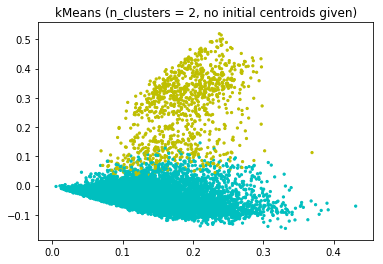

In [40]:
draw_plot(eval_data_truncated, random_predicted_2_cluster)
plt.title("kMeans (n_clusters = 2, no initial centroids given)")

In [41]:
def get_color_array(y):
    color_map = ['c', 'y', 'b', 'm']
    color = []
    for label in y:
        if label == 0:
            color.append(color_map[0])
        elif label == 1:
            color.append(color_map[1])
        elif label == 2:
            color.append(color_map[2])
        else: 
            color.append(color_map[3])
    return color

In [42]:
kMeans_random_3_cluster = KMeans(n_clusters=3).fit(train_data)
random_predicted_3_cluster = kMeans_random_3_cluster.predict(eval_data)

Text(0.5,1,'kMeans (n_clusters = 3, no initial centroids given)')

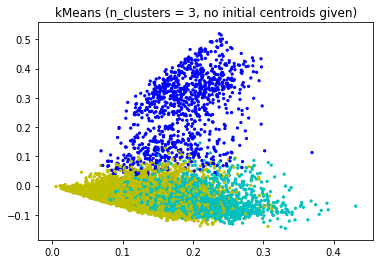

In [48]:
plt.scatter(eval_data_truncated[:,0],eval_data_truncated[:,1],
            color=get_color_array(random_predicted_3_cluster),s=5)
plt.title("kMeans (n_clusters = 3, no initial centroids given)")

In [46]:
kMeans_random_4_cluster = KMeans(n_clusters=4).fit(train_data)
random_predicted_4_cluster = kMeans_random_4_cluster.fit_predict(eval_data)

Text(0.5,1,'kMeans (n_clusters = 4, no initial centroids given)')

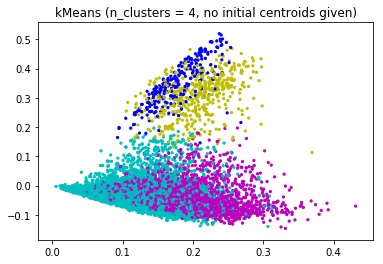

In [56]:
plt.scatter(eval_data_truncated[:,0],eval_data_truncated[:,1],
            color=get_color_array(random_predicted_4_cluster), s=5)
plt.title("kMeans (n_clusters = 4, no initial centroids given)")